In [1]:
import sqlalchemy as sql
import pandas as pd
import glob
from os import path, sep
import numpy as np
import matplotlib.pyplot as plt

In [2]:
server = "thesis.ca6j6heoraog.eu-central-1.rds.amazonaws.com"
engine = sql.create_engine(f"mysql+pymysql://admin:FphvsYQek4@{server}/thesis_db")
con = engine.connect()

In [3]:
query_text = sql.text("""
select data_ordinal, 
	a_value, 
    group_concat(b_value ORDER BY event_start_time) b_values,
    group_concat(
		cast( 100*(
			event_end_time-event_start_time)/(a_end_time-a_start_time) 
            as decimal(4,2) 
            ) ORDER BY event_start_time
		) p

from (
select a.data_ordinal, a.start_time a_start_time, a.end_time a_end_time, greatest(a.start_time,b.start_time) event_start_time, least(a.end_time, b.end_time) event_end_time, a.data_time_diff a_value, b.data_time_diff b_value
from 
( select data_ordinal, data_time-data_time_diff start_time, data_time end_time, data_time_diff
from raw_interval_data
where participant_id = :par1
and series_type_id= 1 ) a
inner join
(select data_time-data_time_diff start_time, data_time end_time, data_time_diff
from raw_interval_data
where participant_id = :par2
and series_type_id = 1 ) b
on (a.start_time <= b.start_time and a.end_time >= b.start_time or a.start_time <= b.end_time and a.end_time >= b.end_time)
) c
group by data_ordinal
""")

In [4]:
partid_query = """
SELECT DISTINCT participant_id
FROM raw_interval_data
"""
participants = [a[0] for a in con.execute(partid_query)]


In [5]:
participants

[101,
 102,
 103,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 155,
 156,
 157,
 158,
 159,
 160,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256]

In [6]:
np.random.shuffle(participants)

In [96]:
def get_xy_from_raw_times_query(r):
    for row in r:
        row = dict(row)
        a_value = row['a_value']
        try: 
            b_value_list = np.array([float(x) for x in row['b_values'].split(',')])
            p_value_list = np.array([float(x) for x in row['p'].split(',')])
            b_mean = np.dot(b_value_list, p_value_list)*0.01
            yield [a_value, b_mean]
        except:
            yield [np.nan, np.nan]

In [97]:
def get_corrcoeff_for_participant_pair(participants, qt):
    for a in range(len(participants)-1):
        r = con.execute(qt,par1=participants[a],par2=participants[a+1])
        all_values = np.array(list(get_xy_from_raw_times_query(r)),dtype=float)
        #print(all_values.shape)
        c = np.corrcoef(all_values.T)
        yield {'par1': participants[a], 'par2': participants[a+1], 'corr': c[1,0]}
    
    
    

        #     df = pd.DataFrame(r.fetchall())
#     df.columns = df.keys()
#     df['b_value_list'] = df.b_values.map(lambda v: [float(x) for x in v.split(',')])
#     df['p_value_list'] = df.p.map(lambda v: [float(x) for x in v.split(',')])

#     df['b_value_list'] = df.b_value_list.map(lambda v: np.array(v))
#     df['p_value_list'] = df.p_value_list.map(lambda v: np.array(v))

#     df['b_mean'] = df.apply(lambda r: np.array(r[4]).dot(np.array(r[5]))*0.01,axis=1)


In [98]:
y = get_corrcoeff_for_participant_pair(participants, query_text)


In [99]:
df= pd.DataFrame(y)
df

,par1,par2,corr
0,145,160,-0.080739
1,160,109,-0.072028
2,109,110,-0.051455
3,110,112,0.173066
4,112,156,-0.045935
...,...,...,...
135,108,170,0.089581
136,170,123,0.173476
137,123,135,-0.157171
138,135,235,NaN


In [100]:
len(df.dropna().index)

106

In [55]:
get_interpolated_series_text = sql.text("""
select data_time, a.data_value par1_val, b.data_value par2_val
from interpolated_interval_data a
inner join interpolated_interval_data b using(data_time, interpolation_series_id, series_type_id)
where a.participant_id = :par1
and b.participant_id = :par2
and interpolation_series_id = 3
and series_type_id = 1
and a.data_value is not null
and b.data_value is not null
""")

In [103]:
def correlate_from_interpolated(participants,qt):     
    for a in range(len(participants)-1):
        r = con.execute(qt, par1 = participants[a], par2=participants[a+1])
        df = pd.DataFrame(r.fetchall())
        df.columns = r.keys()
        c = np.corrcoef(df.par1_val.to_numpy().astype(float),df.par2_val.to_numpy().astype(float))[1,0]
        yield c

In [104]:
a= pd.Series(correlate_from_interpolated(participants, get_interpolated_series_text))

#y = correlate_from_interpolated(participants, get_interpolated_series_text)                        

In [105]:
len(a)

140

In [106]:
df['interp_corr'] = a
df

,par1,par2,corr,interp_corr
0,145,160,-0.080739,-0.051749
1,160,109,-0.072028,-0.131698
2,109,110,-0.051455,-0.050501
3,110,112,0.173066,0.164344
4,112,156,-0.045935,-0.078066
...,...,...,...,...
135,108,170,0.089581,0.047660
136,170,123,0.173476,0.135527
137,123,135,-0.157171,-0.208813
138,135,235,NaN,-0.208952


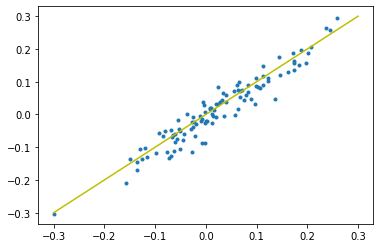

In [112]:
plt.plot(df['corr'],df.interp_corr,'.')
plt.plot([-0.3, 0.3], [-0.3, 0.3], 'y-')

In [113]:
con.close()
con.closed

True

In [68]:
np.corrcoef(tmp.par1_val.to_numpy().astype(float),tmp.par2_val.to_numpy().astype(float))[1,0]

-0.05174903051967282

In [18]:
from collections import namedtuple
dict(next(r))

{'data_ordinal': 6,
 'a_value': Decimal('0.96200'),
 'b_values': '1.12800,1.15200',
 'p': '62.58,37.42'}